# ---------------------------------------------
# LOAD LIBRARIES AND DATA

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import xgboost
import sklearn.metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import lightgbm as lgb
!pip install optuna
import optuna
import optuna.integration.lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
from lightgbm import early_stopping
from lightgbm import log_evaluation
import patsy
import re
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving card_transdata.csv to card_transdata.csv


In [ ]:
df = pd.read_csv('card_transdata.csv')

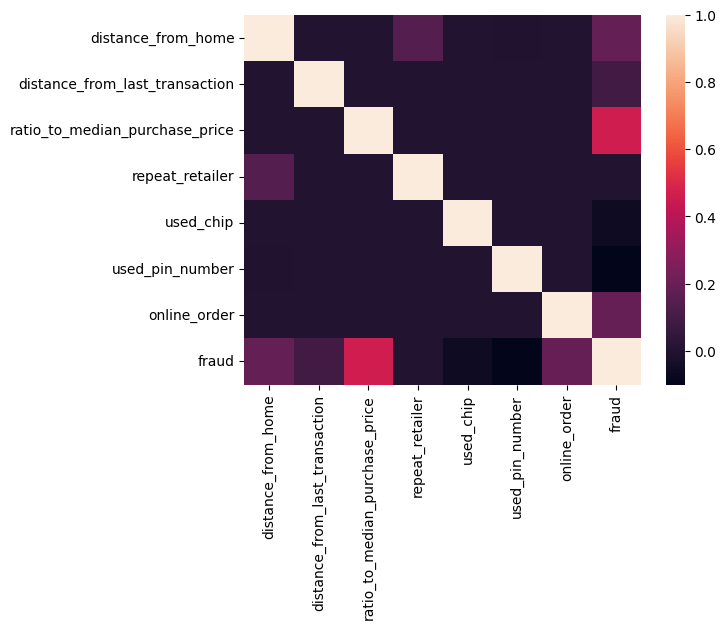

In [ ]:
# Check correlation
numeric_cols = list(df.select_dtypes('number').columns.values)
correlation  = df[numeric_cols].corr()

sns.heatmap(correlation);

In [ ]:
# Check feature importance
Y = df.loc[:,'fraud']
X = df.loc[:, df.columns != 'fraud']
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Print best features
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.nlargest(7,'Score').set_index('Specs')

,Score
Specs,
ratio_to_median_purchase_price,271820.173833
online_order,38263.518281
distance_from_home,36465.693326
used_pin_number,10160.776030
distance_from_last_transaction,8520.690791
used_chip,3731.768465
repeat_retailer,1.842670


In [ ]:
# Check NAs
df.info()
print(df.isna().sum())

In [ ]:
# Get the count of rows for each fraud type
rows_count = df.groupby('fraud').apply(len)
print(rows_count)

fraud
0.0    912597
1.0     87403
dtype: int64


In [ ]:
# Split the data into Training/testing sets
X = df.drop('fraud', axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# -------------------------------------
# SCALE NUMERIC FEATURES

In [ ]:
# Setup scaler
scaler = StandardScaler()

# (with base model, scaling only improved performance marginally)
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scale = pd.DataFrame(scaler.fit_transform(X_test),columns=X_test.columns)

# ---------------------------------------------
# MODEL BUILDING

In [ ]:
# Undersampling (i.e. taking fewer non-fraudulent transactions)
rus = RandomUnderSampler(random_state=0)
X_train_scale_und, y_train_und = rus.fit_resample(X_train_scale, y_train)
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Undersampled training set class distribution: [74350 74350]


Decision Tree

In [ ]:
# Create base line decision tree model
clf = DecisionTreeClassifier(random_state=0, criterion="entropy" )
clf.fit(X_train_scale_und, y_train_und)

# Check performance
y_pred_clf = clf.predict(X_test_scale)
print(classification_report(y_test, y_pred_clf))
print(confusion_matrix(y_test, y_pred_clf))
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_clf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_clf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_clf)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    136947
         1.0       0.98      0.98      0.98     13053

    accuracy                           1.00    150000
   macro avg       0.99      0.99      0.99    150000
weighted avg       1.00      1.00      1.00    150000

[[136725    222]
 [   320  12733]]
Accuracy = 1.00
F1 Score = 0.98
Log Loss = 0.13


Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train_scale_und, y_train_und)

# Check performance
y_pred_lr = lr.predict(X_test_scale)
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_lr)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_lr)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_lr)))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96    136947
         1.0       0.58      0.95      0.72     13053

    accuracy                           0.94    150000
   macro avg       0.79      0.94      0.84    150000
weighted avg       0.96      0.94      0.94    150000

[[127899   9048]
 [   637  12416]]
Accuracy = 0.94
F1 Score = 0.72
Log Loss = 2.33


Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_scale_und, y_train_und)

# Check performance
y_pred_rf = rf.predict(X_test_scale)
print(classification_report(y_test, y_pred_rf))
print('Confusion Matrix : \n', confusion_matrix(y_test, y_pred_rf))
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_rf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_rf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_rf)))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
specificity = tn / (tn+fp)
print('specificity = {:.2f}', specificity)
sensitivity = tp / (tp+fn)
print('sensitivity = {:.2f}', sensitivity)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    136947
         1.0       0.98      0.98      0.98     13053

    accuracy                           1.00    150000
   macro avg       0.99      0.99      0.99    150000
weighted avg       1.00      1.00      1.00    150000

Confusion Matrix : 
 [[136723    224]
 [   300  12753]]
Accuracy = 1.00
F1 Score = 0.98
Log Loss = 0.13
specificity = {:.2f} 0.9983643307264854
sensitivity = {:.2f} 0.9770167777522408


In [ ]:
# Grid search on best parameter
grid = {'n_estimators': [50,100,150], 'max_depth': [1,3,5], 'max_features': ['sqrt', 'log2', None], 'max_leaf_nodes': [3, 6, 9],  'random_state': [0]}
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=grid, cv=10)
grid_search.fit(X_train_scale_und, y_train_und)
print(grid_search.best_estimator_)


RandomForestClassifier(max_depth=5, max_leaf_nodes=9, n_estimators=50,
                       random_state=0)


In [ ]:
# Create best tuned model
rf = RandomForestClassifier(n_estimators=50, max_depth=5,  max_leaf_nodes=9,random_state=0)
rf.fit(X_train_scale_und, y_train_und)
y_pred_rf = rf.predict(X_test_scale)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_rf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_rf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_rf)))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    136947
         1.0       0.86      0.98      0.91     13053

    accuracy                           0.98    150000
   macro avg       0.93      0.98      0.95    150000
weighted avg       0.99      0.98      0.98    150000

[[134798   2149]
 [   286  12767]]
Accuracy = 0.98
F1 Score = 0.91
Log Loss = 0.59


In [ ]:
# Random search on best parameter
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions = grid, cv = 10)
random_search.fit(X_train_scale_und, y_train_und)
print(random_search.best_estimator_)


RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=150,
                       random_state=0)


In [ ]:
# Create best tuned model
rf = RandomForestClassifier(n_estimators=150, max_depth=3,  max_leaf_nodes=3,random_state=0)
rf.fit(X_train_scale_und, y_train_und)
y_pred_rf = rf.predict(X_test_scale)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_rf)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_rf)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_rf)))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97    136947
         1.0       0.64      0.98      0.78     13053

    accuracy                           0.95    150000
   macro avg       0.82      0.96      0.87    150000
weighted avg       0.97      0.95      0.96    150000

[[129877   7070]
 [   270  12783]]
Accuracy = 0.95
F1 Score = 0.78
Log Loss = 1.76


XGBoost

In [ ]:
xgclassifier = xgboost.XGBClassifier(use_label_encoder=False,eval_metric="auc",seed=0)

# Cross validate using auc as our metric and print out average of all folds
cv_scores = cross_val_score(xgclassifier, X_train_scale_und, y_train_und, cv=5, scoring='roc_auc')
print("\nModel, K={:3d} CV, ROC AUC: {:0.3f} +/- {:0.2f}".format(15, np.mean(cv_scores), np.std(cv_scores)))

# Now fit xgboost classifier and predict
xgclassifier.fit(X_train_scale_und, y_train_und)
y_pred_xgb = xgclassifier.predict(X_test_scale)

print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_xgb)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_xgb)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_xgb)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarnin


Model, K= 15 CV, ROC AUC: 1.000 +/- 0.00
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    136947
         1.0       0.98      0.96      0.97     13053

    accuracy                           0.99    150000
   macro avg       0.99      0.98      0.98    150000
weighted avg       0.99      0.99      0.99    150000

[[136722    225]
 [   533  12520]]
Accuracy = 0.99
F1 Score = 0.97
Log Loss = 0.18


XGBoost with Optuna

In [ ]:
SEED = 108
N_FOLDS = 5


def objective(trial):
    dtrain = xgboost.DMatrix(X_train_scale_und, label=y_train_und)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 12),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 6),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }

    xgb_cv_results = xgboost.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        nfold=N_FOLDS,
        stratified=True,
        early_stopping_rounds=100,
        seed=SEED,
        verbose_eval=False,
    )

    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))


    # Extract the best score.
    best_score = xgb_cv_results["test-auc-mean"].values[-1]
    return best_score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))


[I 2023-06-13 21:23:55,401] A new study created in memory with name: no-name-024b1c9e-e4d5-47a4-a0e5-7a5a6ae388be
[I 2023-06-13 21:30:20,160] Trial 0 finished with value: 0.9999995667450113 and parameters: {'lambda': 4.720192222642106e-08, 'alpha': 0.0007314265084022067, 'subsample': 0.31357887750497904, 'colsample_bytree': 0.9340427154351825, 'max_depth': 11, 'min_child_weight': 3, 'eta': 3.705362537555073e-08, 'gamma': 6.715718334720067e-07, 'scale_pos_weight': 1, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9999995667450113.
[I 2023-06-13 21:33:26,540] Trial 1 finished with value: 0.9999998154822178 and parameters: {'lambda': 3.5502916148574965e-05, 'alpha': 0.0009003319139426627, 'subsample': 0.46975781637159164, 'colsample_bytree': 0.8255503762677774, 'max_depth': 13, 'min_child_weight': 6, 'eta': 0.001957882048975051, 'gamma': 3.6878241671905844e-05, 'scale_pos_weight': 6, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.9999998154822178.
[I 2023-06-13 21:

Number of finished trials:  50
Best trial:
  Value: 0.9999999927640086
  Params: 
    lambda: 0.9434209853441222
    alpha: 5.8981104317209535e-06
    subsample: 0.40789046164531456
    colsample_bytree: 0.6164682031084696
    max_depth: 12
    min_child_weight: 2
    eta: 0.04916706715170347
    gamma: 0.7965300901207384
    scale_pos_weight: 5
    grow_policy: lossguide
  Number of estimators: 484


In [ ]:
best_params = {
    "lambda":  0.9434209853441222,
    "alpha": 5.8981104317209535e-06,
    "subsample": 0.40789046164531456,
    "colsample_bytree": 0.6164682031084696,
    "max_depth": 12,
    "min_child_weight": 2,
    "eta": 0.04916706715170347,
    "gamma": 0.7965300901207384,
    "scale_pos_weight": 5,
    "grow_policy": "lossguide",
    "n_estimators": 484
}

In [ ]:
finalxgb = xgboost.XGBClassifier(use_label_encoder=False,eval_metric="auc",seed=0,**best_params)
finalxgb.fit(X_train_scale_und, y_train_und)

# Generate predictions
y_pred_xgb = finalxgb.predict(X_test_scale)

print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_xgb)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_xgb)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_xgb)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    136947
         1.0       0.98      0.96      0.97     13053

    accuracy                           1.00    150000
   macro avg       0.99      0.98      0.98    150000
weighted avg       1.00      1.00      1.00    150000

[[136713    234]
 [   496  12557]]
Accuracy = 1.00
F1 Score = 0.97
Log Loss = 0.18
